In [ ]:
#export
#import torch
import torch.nn as nn
from fastai.vision.all import *
from fastai.data.all import *
from fastai.distributed import *
import pandas as pd
from pathlib import Path
import time
from datetime import date
from vidaug import augmentors as va

import torchvision.transforms as T


from modules_th.video_block import * 
from modules_th.inflator import *
from modules_th.triplet_loss import *
from modules_th.supcon_module import *
from modules_th.cus_cbs import *

#Pretrained models
from modules_th.pretrained_r2p1d50 import *
from resnetmodels.mean import get_mean_std

In [ ]:
#export
def read_data():
    prefix = '/mnt/data/eugeniomarinelli/'
    items_path = prefix + 'videodata/ucf101.csv'
    return pd.read_csv(items_path, index_col=0)

In [ ]:
df = read_data()
df = df.sample(frac=0.01)

In [ ]:
# export
def sometimes(x):
    return va.Sometimes(0.5,x)
    
def wrapVideo(x):
    return Video(x)

In [ ]:
#export
def get_dsets(df, l=40, size=512,skip=20,n_views=2):
    vid_paths = df.vid_files.values
    prefix = Path('/mnt/data/eugeniomarinelli/videodata/UCF-101/')
    vid_paths = [prefix/file for file in vid_paths]
    
    
    vid_pip = [createVideoForm(l=l,skip=skip, form='img'), 
               Resize(size, method=ResizeMethod.Pad),
               sometimes(va.HorizontalFlip()),
#               va.GaussianBlur(1.),
#               sometimes(va.InvertColor()),
               va.RandomRotate(10),
               wrapVideo]

    lbl_pip = [parent_label, Categorize()]           
    pip = [*([vid_pip]*n_views), lbl_pip]
    #splits
    splits = ColSplitter('val')(df)

    # Datasets and dataloaders
    dsets = Datasets(vid_paths, pip, splits=splits)
    return dsets, splits

In [ ]:
ColSplitter('val')(df)

((#90) [0,1,2,3,4,5,6,7,11,12...], (#43) [8,9,10,19,23,26,29,37,41,46...])

In [ ]:
dsets,splits = get_dsets(df)
vid = dsets[0][0]

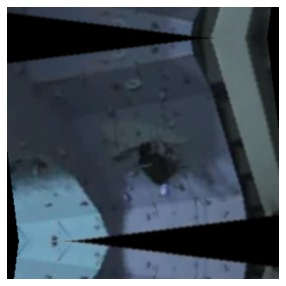

In [ ]:
vid.show()

In [ ]:
# export
def get_dls(dsets,splits,df, n_el= 2, n_lbl = 2, shuffle_fn= UniformizedShuffle, normalize='kinetics'):
        
    mean, std = get_mean_std(1,normalize)
    dls  = dsets.dataloaders(bs=n_el*n_lbl, 
                             shuffle_train=True,
                             after_item=ToTensor(),
                             after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)])
    
    dls.valid.shuffle = True
    if shuffle_fn is not None:
        dls.train.shuffle_fn = UniformizedShuffle(df.lbls.iloc[splits[0]], n_el = n_el, n_lbl= n_lbl)
        dls.valid.shuffle_fn = UniformizedShuffle(df.lbls.iloc[splits[1]], n_el = n_el, n_lbl= n_lbl)
    return dls
    

In [ ]:
dls = get_dls(dsets,splits,df, normalize='kinetics')


In [ ]:
#export
def setup_log(learn,name, append=True):
     # set up logs file
    # now = datetime.now()
    # time = now.strftimes("%d_%m")
    logs_file = '/mnt/data/eugeniomarinelli/UCF_experiments/training_results/logs_ucf101_'+name+'.csv'
    Logs_csv =   CSVLogger(fname= logs_file, append=append)    
    learn.add_cb(Logs_csv)

{'r2p1d50_KM': <function modules_th.pretrained_r2p1d50.r2p1d_model_KM(pretrained=False, progress=True)>,
 'r2p1d50_K': <function modules_th.pretrained_r2p1d50.r2p1d_model_K(pretrained=False, progress=True)>,
 'res50_2d': <function torchvision.models.resnet.resnet50(pretrained=False, progress=True, **kwargs)>}

In [ ]:
#export
def get_learner(df,
                pretrained_model='r2p1d50_K',  
                loss_name='CEL_after_SCL', 
                l=40, size=224, n_lbl =2, n_el=2, skip=20, embs_size=256,n_views=2, 
                normalize = 'kinetics'):

    dsets,splits = get_dsets(df, l, size, skip, n_views)

    dls = get_dls(dsets,splits,df, normalize=normalize)
    
    if pretrained_model in inserted_models:
        model = inserted_models[pretrained_model]
    else: raise 'model not present in pretrained models'
   

    body = create_body(model, cut=-2)
        


    if loss_name == 'SCL+CEL':
        Loss = SumLoss(SupConLoss,p='cos', alpha=1, n_views=n_views)
        head = inflate(create_head(256, len(dls.vocab), lin_ftrs=[]))
        model = MixedLossModel(body,head)
        metrics = [supcon_accuracy, silh_score]
        
        
    elif loss_name == 'SCL':
        Loss= SupConLoss() 
        head = inflate(create_head(4096, embs_size, lin_ftrs=[]))
        model = nn.Sequential(body,head)
        metrics = [silh_score]
        
        
    elif loss_name == 'CEL':
        Loss = CEL()
        head = inflate(create_head(4096, len(dls.vocab), lin_ftrs=[256]))
        model = MixedLossModel(body,head)
        metrics = [supcon_accuracy,silh_score]
        
    elif loss_name == 'CEL_after_SCL':
        Loss = CrossEntropyLossFlat()
        saved_model = torch.load('/mnt/data/eugeniomarinelli/UCF_experiments/trained_models_cnn/models/r2p1d50_ucf101_SCL_tuned_15fr.pth')
        model = nn.Sequential(saved_model,nn.Sequential(nn.ReLU(inplace=True),LinBnDrop(256, 101, p=0.5)))
        metrics = [accuracy]
    else:
        raise 'Loss not implemented'

    
        
    learn = Learner(dls, 
                model,
                splitter=splitter ,
                loss_func=Loss,
                metrics=metrics)

    if loss_name == 'SCL+CEL':
        learn.add_cbs([ContrastiveCallback(n_views)])#,LossesRecorderCallback()])
    elif loss_name == 'SCL':
        learn.add_cb(ContrastiveCallback(n_views))
    elif loss_name in ['CEL', 'CEL_after_SC']:
        learn.add_cb(MultiViewsCallback(n_views))
    time = date.today().strftime("_%d-%m")
        
    setup_log(learn, str(pretrained_model)+loss_name+'5fr_20unf'+time, append=True)
   
    return learn
 

In [ ]:
### Per fare ulteriori allenamenti
def __get_learner__(df,
                pretrained_model='r2p1d50_K',  
                loss_name='CEL_after_SCL', 
                l=40, size=224, n_lbl =2, n_el=2, skip=20, embs_size=256,n_views=2, 
                normalize = 'kinetics'):

    dsets,splits = get_dsets(df, l, size, skip, n_views)

    dls = get_dls(dsets,splits,df, normalize=normalize)
    
    
   

    model = torch.load('/mnt/data/eugeniomarinelli/UCF_experiments/trained_models_cnn/models/model_ucf101_r2p1d50_K_CEL_finetuned_20_5fr.pth')

       
    learn = Learner(dls, 
                model,
                splitter=splitter ,
                loss_func=SupConLoss(),
                metrics=silh_score)


    learn.add_cb(ContrastiveCallback(n_views))

    time = date.today().strftime("_%d-%m")
        
    setup_log(learn, str(pretrained_model)+loss_name+'5fr_20unf'+time, append=True)
   
    return learn
 

In [ ]:
learn = get_learner(df, 'r2p1d50_K', loss_name='CEL_after_SCL', l=2, size=64, n_lbl =2, n_el=2, skip=20, embs_size=256, n_views=2)
#learn.add_cb(CSVLogger(fname='data/eugeniomarinelli/UCF_experiments/trained_models_cnn/learners/LOGGER_PROVA' , append=False)  )

NameError: name 'df' is not defined

In [ ]:
from datetime import date
date.today().strftime("_%d-%m")

'_23-01'

In [ ]:
learn.fit_one_cycle(1)

In [ ]:
inp = torch.randn(8,3,30,100,100).cuda()
model = learn.model.cuda()
model(inp).shape

torch.Size([8, 101])

In [ ]:
#export
def save_learner(learn, name):
    prefix = '/mnt/data/eugeniomarinelli/'
    try:
        learn.export(prefix+'UCF_experiments/trained_models_cnn/learners/learner_ucf101_'+name)
    except: print("learner export didn't work") 
    try:
        torch.save(learn.model,prefix+'UCF_experiments/trained_models_cnn/models/model_ucf101_'+name+'.pth')
    except: torch.save(learn.model.state_dict(),prefix+'UCF_experiments/trained_models_cnn/models/state_dict_ucf101_'+name)
    


In [ ]:
learn.export('/mnt/data/eugeniomarinelli/UCF_experiments/trained_models_cnn/learners/LEARNER_CANCELLARE')
torch.save(learn.model, '/mnt/data/eugeniomarinelli/UCF_experiments/trained_models_cnn/models/MODEL_CANCELLARE')

In [ ]:
b = torch.load('/mnt/data/eugeniomarinelli/UCF_experiments/trained_models_cnn/learners/learner_ucf101_XXXXXX.pth')

In [ ]:
saved_model_SCL = torch.load('/mnt/data/eugeniomarinelli/UCF_experiments/trained_models_cnn/models/r2p1d50_ucf101_SCL_tuned_15fr.pth')

In [ ]:

model = nn.Sequential(saved_model_SCL,nn.Sequential(nn.ReLU(inplace=True),LinBnDrop(256, 101, p=0.5)))


In [ ]:
len(splitter(model))

2

In [ ]:
saved_model.head

Sequential(
  (0): AdaptiveConcatPool3d(
    (ap): AdaptiveAvgPool3d(output_size=1)
    (mp): AdaptiveMaxPool3d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=256, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=256, out_features=101, bias=False)
)

In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_losses_tmp.ipynb.
Converted 02_inflator.ipynb.
Converted 03_video_block.ipynb.
Converted 05_charades.ipynb.
Converted 07_read_video_function.ipynb.
Converted 08_transformer.ipynb.
Converted 09_lr_schedule.ipynb.
Converted 10_experiments_on_images.ipynb.
Converted 11_create_embeddings.ipynb.
Converted 12_load_r2p1d_model.ipynb.
Converted CALTECH101_MixedLoss.ipynb.
Converted CALTECH101_singleloss.ipynb.
Converted UCF101.ipynb.
Converted UCF_Crimes_CEL.ipynb.
Converted UCF_Crimes_SupCon.ipynb.
Converted index.ipynb.


In [ ]:
#default_exp ucf101

Path('/mnt/data/eugeniomarinelli/videodata/UCF-101')

RuntimeError: [enforce fail at inline_container.cc:222] . file not found: archive/data.pkl